## Renko chart Strategy


### Renko chart is a chart itself that came from Japan where renki means bricks
###  It only form a brick in the chart when a stock moves by a dollar or custome value amount
### Buy the stock when three consecutive green bricks are formed and sell when two consecutive bricks are formed

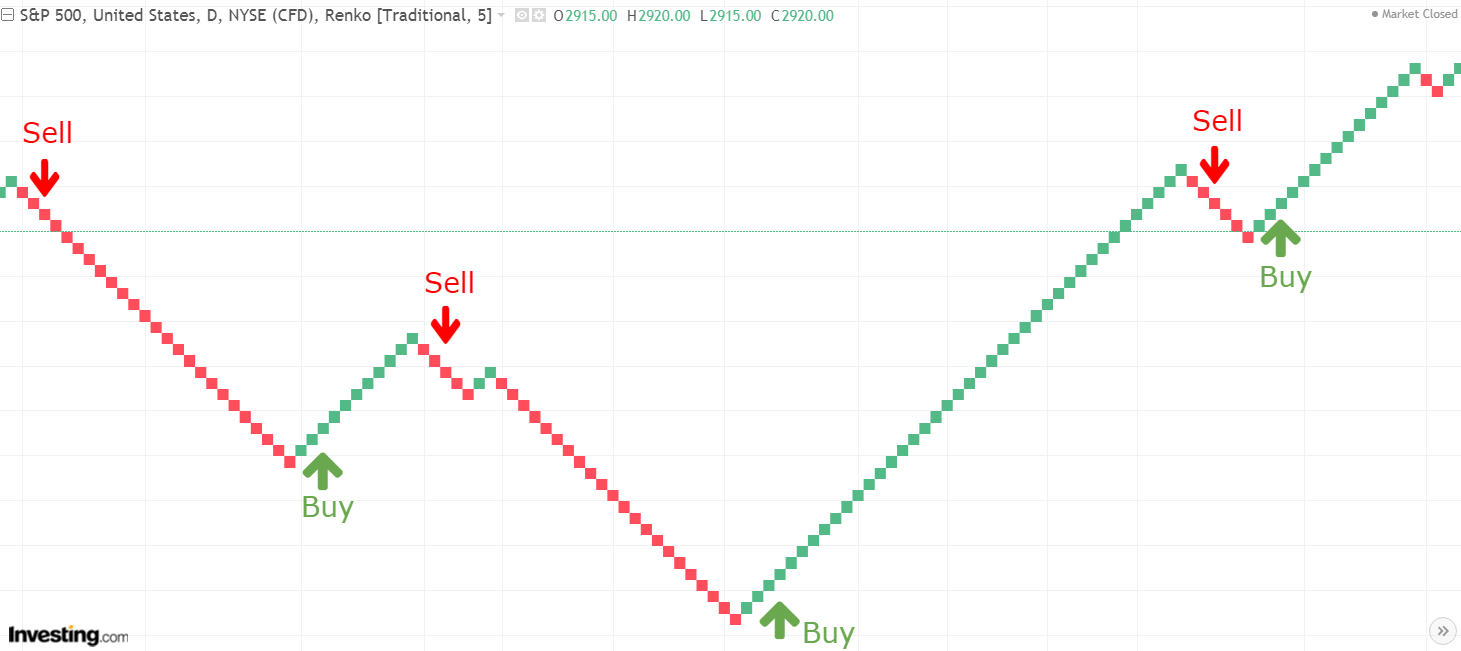

In [52]:
import numpy as np
import pandas as pd
import copy
import time
import datetime as dt
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from stocktrends import Renko

In [53]:
def ATR(DF,n):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Adj Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Adj Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2

In [54]:
def slope(ser,n):
    "function to calculate the slope of n consecutive points on a plot"
    slopes = [i*0 for i in range(n-1)]
    for i in range(n,len(ser)+1):
        y = ser[i-n:i]
        x = np.array(range(n))
        y_scaled = (y - y.min())/(y.max() - y.min())
        x_scaled = (x - x.min())/(x.max() - x.min())
        x_scaled = sm.add_constant(x_scaled)
        model = sm.OLS(y_scaled,x_scaled)
        results = model.fit()
        slopes.append(results.params[-1])
    slope_angle = (np.rad2deg(np.arctan(np.array(slopes))))
    return np.array(slope_angle)

In [55]:
def renko_DF(DF):
    "function to convert ohlc data into renko bricks"
    df = DF.copy()
    df.reset_index(inplace=True)
    df = df.iloc[:,[0,1,2,3,4,5]]
    df.columns = ["date","open","high","low","close","volume"]
    df2 = Renko(df)
    df2.brick_size = max(0.5,round(ATR(DF,120)["ATR"][-1],0))
    renko_df = df2.get_ohlc_data()
    renko_df["bar_num"] = np.where(renko_df["uptrend"]==True,1,np.where(renko_df["uptrend"]==False,-1,0))
    for i in range(1,len(renko_df["bar_num"])):
        if renko_df["bar_num"][i]>0 and renko_df["bar_num"][i-1]>0:
            renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
        elif renko_df["bar_num"][i]<0 and renko_df["bar_num"][i-1]<0:
            renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
    renko_df.drop_duplicates(subset="date",keep="last",inplace=True)
    return renko_df

In [56]:
def OBV(DF):
    """function to calculate On Balance Volume"""
    df = DF.copy()
    df['daily_ret'] = df['Adj Close'].pct_change()
    df['direction'] = np.where(df['daily_ret']>=0,1,-1)
    df['direction'][0] = 0
    df['vol_adj'] = df['Volume'] * df['direction']
    df['obv'] = df['vol_adj'].cumsum()
    return df['obv']

In [57]:
def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    n = len(df)/(252*78)
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

In [58]:
def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["ret"].std() * np.sqrt(252*78)
    return vol

In [59]:
def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr

In [60]:
def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

In [61]:
# Download historical data for DJI constituent stocks

tickers = ["TSLA","MSFT","NVDA","AMZN"]


In [62]:
ohlc_intra={} #directory with ohlc value for each stock
start=dt.datetime.today()-dt.timedelta(days=7)
end=dt.datetime.today()

for ticker in tickers:
    ohlc_intra[ticker]=yf.download(ticker,start=start,end=end,interval='1m')
    ohlc_intra[ticker].dropna(inplace=True,how="all")

tickers=ohlc_intra.keys()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [63]:
ATR(ohlc_intra["TSLA"],120)

,Open,High,Low,Close,Adj Close,Volume,TR,ATR
Datetime,,,,,,,,
2022-10-18 15:07:00-04:00,218.425003,218.639999,218.339996,218.632401,218.632401,0,NaN,NaN
2022-10-18 15:08:00-04:00,218.600006,218.673294,218.339996,218.520004,218.520004,65641,0.333298,NaN
2022-10-18 15:09:00-04:00,218.570007,218.580002,218.110001,218.119995,218.119995,69177,0.470001,NaN
2022-10-18 15:10:00-04:00,218.145004,218.380005,218.050095,218.095001,218.095001,74027,0.329910,NaN
2022-10-18 15:11:00-04:00,218.059998,218.309998,217.960098,218.050003,218.050003,88442,0.349899,NaN
...,...,...,...,...,...,...,...,...
2022-10-25 15:02:00-04:00,221.740005,221.770004,221.479996,221.488297,221.488297,102332,0.290009,0.426833
2022-10-25 15:03:00-04:00,221.464996,221.649994,221.423294,221.649994,221.649994,84639,0.226700,0.417889
2022-10-25 15:04:00-04:00,221.649994,221.789993,221.600006,221.789993,221.789993,127936,0.189987,0.415567


In [64]:
#Merging renko df with original ohlc df
ohlc_renko = {}
df = copy.deepcopy(ohlc_intra)
tickers_signal = {}
tickers_ret = {}
for ticker in tickers:
    print("merging for ",ticker)
    renko = renko_DF(df[ticker])
    renko.columns = ["Date","open","high","low","close","uptrend","bar_num"]
    df[ticker]["Date"] = df[ticker].index
    ohlc_renko[ticker] = df[ticker].merge(renko.loc[:,["Date","bar_num"]],how="outer",on="Date")
    ohlc_renko[ticker]["bar_num"].fillna(method='ffill',inplace=True)
    ohlc_renko[ticker]["obv"]= OBV(ohlc_renko[ticker])
    ohlc_renko[ticker]["obv_slope"]= slope(ohlc_renko[ticker]["obv"],5)
    tickers_signal[ticker] = ""
    tickers_ret[ticker] = []

merging for  TSLA


/var/folders/0d/2q3_g9bj7tn1m1t1w5crmtvh0000gn/T/ipykernel_12308/2866808216.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
/var/folders/0d/2q3_g9bj7tn1m1t1w5crmtvh0000gn/T/ipykernel_12308/2866808216.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
/var/folders/0d/2q3_g9bj7tn1m1t1w5crmtvh0000gn/T/ipykernel_12308/895490428.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

merging for  MSFT


/var/folders/0d/2q3_g9bj7tn1m1t1w5crmtvh0000gn/T/ipykernel_12308/2866808216.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
/var/folders/0d/2q3_g9bj7tn1m1t1w5crmtvh0000gn/T/ipykernel_12308/2866808216.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
/var/folders/0d/2q3_g9bj7tn1m1t1w5crmtvh0000gn/T/ipykernel_12308/895490428.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

merging for  NVDA


/var/folders/0d/2q3_g9bj7tn1m1t1w5crmtvh0000gn/T/ipykernel_12308/2866808216.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
/var/folders/0d/2q3_g9bj7tn1m1t1w5crmtvh0000gn/T/ipykernel_12308/2866808216.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
/var/folders/0d/2q3_g9bj7tn1m1t1w5crmtvh0000gn/T/ipykernel_12308/895490428.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

merging for  AMZN


/var/folders/0d/2q3_g9bj7tn1m1t1w5crmtvh0000gn/T/ipykernel_12308/2866808216.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
/var/folders/0d/2q3_g9bj7tn1m1t1w5crmtvh0000gn/T/ipykernel_12308/2866808216.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
/var/folders/0d/2q3_g9bj7tn1m1t1w5crmtvh0000gn/T/ipykernel_12308/895490428.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

In [65]:
#Identifying signals and calculating daily return
for ticker in tickers:
    print("calculating daily returns for ",ticker)
    for i in range(len(ohlc_intra[ticker])):
        if tickers_signal[ticker] == "":
            tickers_ret[ticker].append(0)
            if ohlc_renko[ticker]["bar_num"][i]>=3:
                tickers_signal[ticker] = "Buy"
            elif ohlc_renko[ticker]["bar_num"][i]<=-2:
                tickers_signal[ticker] = "Sell"
        
        elif tickers_signal[ticker] == "Buy":
            tickers_ret[ticker].append((ohlc_renko[ticker]["Adj Close"][i]/ohlc_renko[ticker]["Adj Close"][i-1])-1)
            if ohlc_renko[ticker]["bar_num"][i]<=-2:
                tickers_signal[ticker] = "Sell"
            elif ohlc_renko[ticker]["bar_num"][i]<3:
                tickers_signal[ticker] = ""
                
        elif tickers_signal[ticker] == "Sell":
            tickers_ret[ticker].append((ohlc_renko[ticker]["Adj Close"][i-1]/ohlc_renko[ticker]["Adj Close"][i])-1)
            if ohlc_renko[ticker]["bar_num"][i]>=3:
                tickers_signal[ticker] = "Buy"
            elif ohlc_renko[ticker]["bar_num"][i]>-3:
                tickers_signal[ticker] = ""
    ohlc_renko[ticker]["ret"] = np.array(tickers_ret[ticker])

calculating daily returns for  TSLA
calculating daily returns for  MSFT
calculating daily returns for  NVDA
calculating daily returns for  AMZN


In [66]:
ohlc_renko["TSLA"]["ret"]

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
1937   -0.000954
1938    0.000730
1939    0.000632
1940   -0.000180
1941    0.000857
Name: ret, Length: 1942, dtype: float64

In [67]:
#calculating overall strategy's KPIs
strategy_df = pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker] = ohlc_renko[ticker]["ret"]
strategy_df["ret"] = strategy_df.mean(axis=1)
print(CAGR(strategy_df))
print(sharpe(strategy_df,0.025))
print(max_dd(strategy_df))

-0.14677906886656256
-1.8694179024913078
0.033851608017407483


<AxesSubplot:>

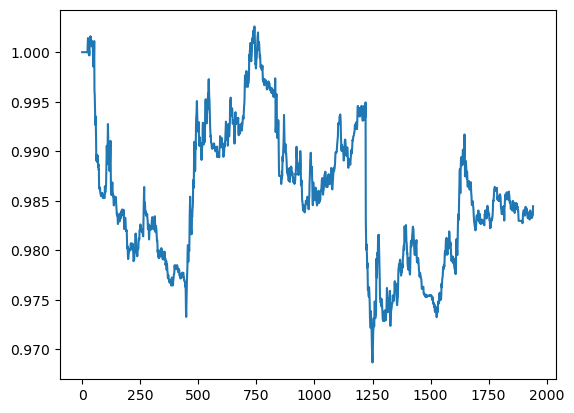

In [68]:
#visualizing strategy returns
(1+strategy_df["ret"]).cumprod().plot()

In [69]:
#calculating individual stock's KPIs
cagr = {}
sharpe_ratios = {}
max_drawdown = {}
for ticker in tickers:
    print("calculating KPIs for ",ticker)      
    cagr[ticker] =  CAGR(ohlc_renko[ticker])
    sharpe_ratios[ticker] =  sharpe(ohlc_renko[ticker],0.025)
    max_drawdown[ticker] =  max_dd(ohlc_renko[ticker])

calculating KPIs for  TSLA
calculating KPIs for  MSFT
calculating KPIs for  NVDA
calculating KPIs for  AMZN


In [70]:
KPI_df = pd.DataFrame([cagr,sharpe_ratios,max_drawdown],index=["Return","Sharpe Ratio","Max Drawdown"])      
KPI_df.T

,Return,Sharpe Ratio,Max Drawdown
TSLA,-0.616066,-2.806653,0.134074
MSFT,-0.090118,-1.270866,0.023086
NVDA,0.904244,4.684679,0.025324
AMZN,-0.253500,-2.203442,0.033337
